In [1]:
%matplotlib inline
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
"""
    All the relevant stuff from Problem 3...
"""

# load stimulus
with open('stimulus.txt','r') as f:
    # create list to store stimulus
    stimulus = []
    # read in every line of file, split into list pairs, convert to float (seconds)
    for line in f:
        stimulus.append([float(v)/1000 for v in line.rstrip().split('\t')])

# load spike file
with open('spikes.txt','r') as f:
    # create list to store spikes
    spikes = []
    # read in every line of file, converting to float
    for line in f:
        spikes.append(float(line.rstrip()))
        
# find the start of each 20 s trial
trial_start = [] # list to store index of start of each trial
trial_start.append(0) # we know first trial starts at first index
trial_num = 1 # look for start of 2nd trial
for n,spike in enumerate(spikes):
    if spike >= trial_num*20: # look for start of trial
        # append start of trail and increment to next trial
        trial_start.append(n)
        trial_num += 1
    if trial_num == 5: # quit after finding 5th trial
        break
# define trial ends
trial_end = trial_start[1:5] + [len(spikes)]

# split trials
trial = [] # list to store each trial
for n,(start,end) in enumerate(zip(trial_start,trial_end)):
    # append spikes to trial list, subtract offset time to get
    # 0 - 20s range
    trial.append([s-n*20 for s in spikes[start:end]])
    
# create Bins to loop over
class Bins:
    """
        Creates bins with generator to iterate over.
        NOTE: start and end parameters of gen method correspond to the units of 
        step to the END of first and last bin rather than the START
    """
    def gen(self,start,end,step,size,dtype=float): # this method generates bins
        # Create bins from start to end units, with step size (step), and size n units (size)
        for t in range(start,end):
            yield ((dtype(t)-size)*step,dtype(t)*step) # bin interval
        
# Discretize stimulus by binning values in 0.1s intervals
stimulus_d = []
for t in Bins().gen(1,201,0.1,1): # loop 20s in 0.1s step
    # overlap flag
    overlap = False
    # for each interval in stimulus check if it is in the bin interval
    for s in stimulus:
        # overlap if start of stimulus if before end of bin and end is before start
        if s[0] <= t[1] and s[1] >= t[0]:
            overlap = True
            break
    # assign 1 if overlap, 0 otherwise
    if overlap:
        stimulus_d.append(1)
    else:
        stimulus_d.append(0)

# Create the S matrix
S = []
# Loop over indicies of 2s bins in 0.1 increments (20s total time)
for i in Bins().gen(20,201,1,20,dtype=int):
    S.append(stimulus_d[i[0]:i[1]])
S = np.array(S) # convert to numpy array

# Create the R matrix
R = []
# Loop over time intervals of 2s bins in 0.1 increments (20s total time)
for b in Bins().gen(20,201,0.1,1):
    # create row to add to R
    row = []
    # loop over all trials
    for t in trial:
        # keep track of spike counts
        spike_count = 0
        # loop over spike time in trial
        for s in t: #
            # overlap if spike in bin interval
            if s <= b[1] and s >= b[0]:
                spike_count += 1
        # append spike_count to the R matrix row
        row.append(spike_count)
    # add row to R
    R.append(row)
R = np.array(R) # convert to numpy array

# Split into model and test data
R_model = np.mean(R[:,0:4], axis=1) # Do mean over the 4 trials
R_test = R[:,4]

# Calculate pseudo-inverse of S matrix
invS = np.linalg.pinv(S)

# Calculate W
W = np.matmul(invS,R_model)

# Create piecewise nonlinear function
filter_output = np.matmul(S,W)
idx = np.argsort(filter_output) # sort filter output
filter_output = filter_output[idx]
R_sort = R_model[idx]
gbins = []
firerate = []
pts = 10 # do every 10 points
# Average r and g across bin, we also round to the nearest integer
for p in range(int(filter_output.shape[0]/pts)):
    gbins.append(np.mean(filter_output[p*pts:(p+1)*pts]))
    firerate.append(np.mean(R_sort[p*pts:(p+1)*pts]))
# Average what is leftover in the last bin 
gbins.append(np.mean(filter_output[(p+1)*pts:]))
firerate.append(np.mean(R_sort[(p+1)*pts:]))

# Create nonlinear function, outputs closest g value in piecewise function
def nonlin(x, b=gbins, f=firerate):
    a = [] # temp array to store values
    for v in x: # loop through all points in input
        # Find bin closest to input x
        _, i = min((val, idx) for (idx, val) in enumerate([abs(i-v) for i in b]))
        # append firerate at that index
        a.append(f[i])
    # return the array
    return np.array(a)

# Calculate times and the LN model output
filter_time = [float(t)/10 for t in range(W.shape[0])] 
time = [float(t)/10 for t in range(R_test.shape[0])]
LN_model = nonlin(np.matmul(S,W))

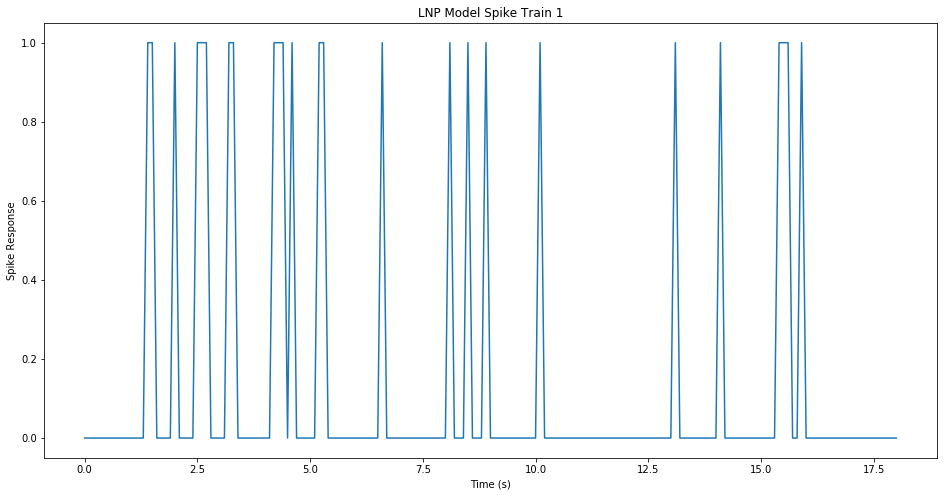

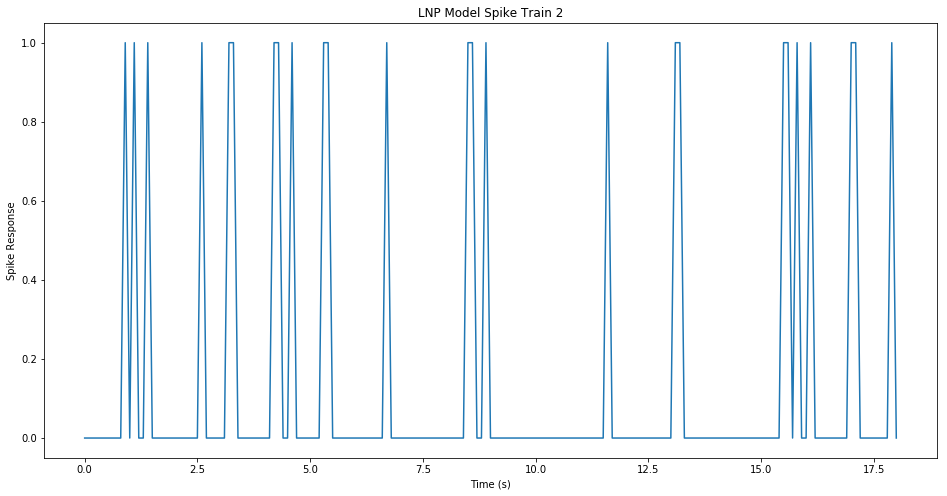

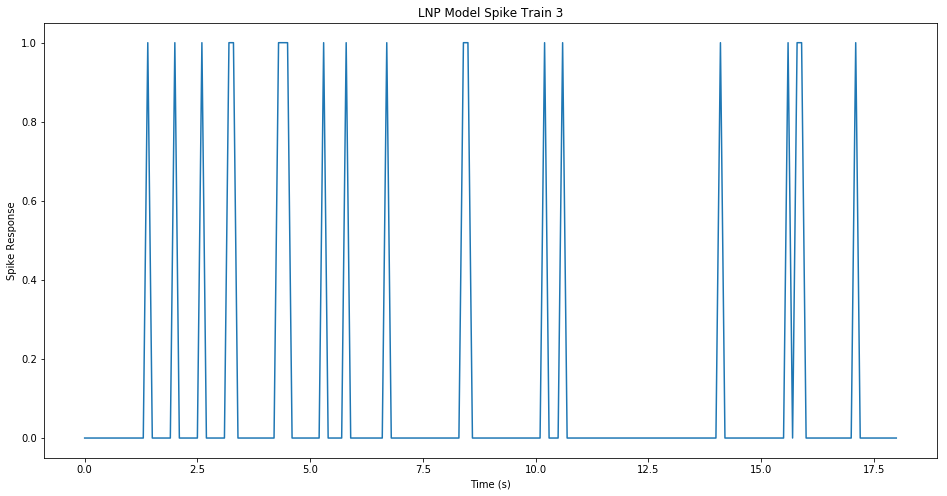

In [3]:
"""
    Create a spike train using inhomogenous Poisson process
"""

# Calculate lambda max
lambda_max = np.max(LN_model)

# Calculate lambda ratios
lambda_ratio = LN_model/lambda_max

# Make n spike trains
n = 1000
LNP_spike_train = np.zeros((*LN_model.shape,n))
for i in range(n):
    # Calculate uniform distribution
    urand = np.random.rand(*LN_model.shape)

    # Calculate Spike Train
    LNP_spike_train[:,i] = urand < lambda_ratio

# plot 3 spike trains
for i in range(3):
    plt.figure(figsize=(16,8))
    plt.plot(time, LNP_spike_train[:,i])
    plt.title('LNP Model Spike Train {}'.format(i+1))
    plt.xlabel('Time (s)')
    plt.ylabel('Spike Response')
plt.show()

Fano Factor: 0.8700552486187841
Coefficient of Variation: 1.071133023919012


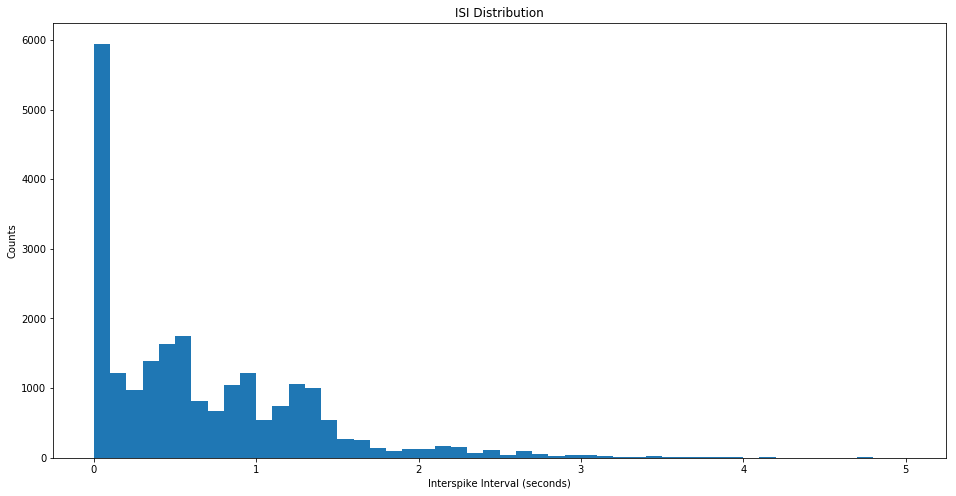

In [4]:
"""
    Calculate ISI Distribution, Fano Factor, Coefficient of Variation
"""

# Interspike Intervals Finder
def isi_finder(array):
    """
        This function finds all isi's in the a given spike train array
    """
    # get index of 1s
    idx = np.argwhere(array).ravel()
    
    # do difference to get lengths of intervals
    intervals = (idx[1:] - idx[0:-1]) - 1 # subtract 1 to only get interval in-between
    
    # return intervals
    return intervals

# Get ISI distribution for generated spike trains
isi_list = []
for i in range(n):
    isi_list.append(isi_finder(LNP_spike_train[:,i])*0.1)
isi = np.concatenate(isi_list)
plt.figure(figsize=(16,8))
plt.hist(isi, bins=50, range=(0,5))
plt.title('ISI Distribution')
plt.xlabel('Interspike Interval (seconds)')
plt.ylabel('Counts')

# Fano Factor
mean_spikes = np.mean(LNP_spike_train.ravel())
variance_spikes = np.var(LNP_spike_train.ravel())
fano_factor = variance_spikes/mean_spikes
print('Fano Factor: {}'.format(fano_factor))

# Coefficient of Variation
mean_isi = np.mean(isi)
std_isi = np.std(isi)
coefficient_of_variation = std_isi/mean_isi 
print('Coefficient of Variation: {}'.format(coefficient_of_variation))

# Show plots
plt.show()